In [1]:
# List available saved models in the current folder
import os
models = [f for f in os.listdir('.') if f.lower().endswith(('.h5', '.joblib', '.pkl'))]
print('Models found in repo root:', models)

Models found in repo root: ['mnist_cnn.h5']


In [2]:
# Imports and helper functions
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_model_auto(path):
    



    ext = os.path.splitext(path)[1].lower()
    if ext in ('.h5', '.keras'):
        try:
            from tensorflow.keras.models import load_model
            return 'keras', load_model(path)
        except Exception as e:
            raise RuntimeError('Failed to load Keras model: '+str(e))
    if ext in ('.joblib', '.pkl'):
        try:
            import joblib
            return 'sklearn', joblib.load(path)
        except Exception as e:
            raise RuntimeError('Failed to load sklearn model: '+str(e))
    # try keras first, then sklearn
    try:
        from tensorflow.keras.models import load_model
        return 'keras', load_model(path)
    except Exception:
        import joblib
        return 'sklearn', joblib.load(path)

def preprocess_for_keras(image_path, invert=False):
    # Keras MNIST model expects (1,28,28,1), values 0-1
    img = Image.open(image_path).convert('L')
    img = img.resize((28,28), Image.Resampling.LANCZOS)
    arr = np.array(img).astype('float32')
    if invert:
        arr = 255.0 - arr
    arr = arr / 255.0
    arr = arr.reshape((1,28,28,1))
    return arr, img

def preprocess_for_sklearn(image_path, invert=False):
    # sklearn digits (8x8) expects shape (n_samples, 64), scaled ~0-16 in original dataset
    img = Image.open(image_path).convert('L')
    img = img.resize((8,8), Image.Resampling.LANCZOS)
    arr = np.array(img).astype('float32')
    if invert:
        arr = 255.0 - arr
    # scale to 0-16 like sklearn digits: divide by 255 and multiply by 16 then flatten
    arr = (arr / 255.0) * 16.0
    arr = arr.reshape((1, -1))
    return arr, img

Detected model type: keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Predicted label: 0
Probabilities: [0.4758724  0.07508563 0.06464657 0.02350072 0.10353672 0.0158121
 0.12036983 0.04709152 0.0630158  0.01106875]
Predicted label: 0
Probabilities: [0.4758724  0.07508563 0.06464657 0.02350072 0.10353672 0.0158121
 0.12036983 0.04709152 0.0630158  0.01106875]


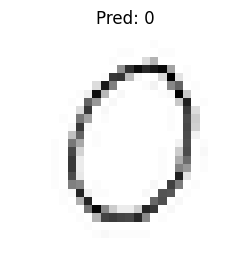

In [4]:
# Configure these paths before running:
MODEL_PATH = 'mnist_cnn.h5'   # change to your model file if different
IMAGE_PATH = 'test_digit.png' # path to the image you want to test
INVERT = False                # set True if foreground/background are inverted

# Load model and run prediction
assert os.path.exists(MODEL_PATH), f'Model file not found: {MODEL_PATH}'
assert os.path.exists(IMAGE_PATH), f'Image file not found: {IMAGE_PATH}'
mtype, model = load_model_auto(MODEL_PATH)
print('Detected model type:', mtype)
if mtype == 'keras':
    x, img = preprocess_for_keras(IMAGE_PATH, invert=INVERT)
    preds = model.predict(x)
    label = int(np.argmax(preds, axis=1)[0])
    print('Predicted label:', label)
    print('Probabilities:', preds[0])
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {label}')
    plt.axis('off')
else:
    # sklearn classifier
    x, img = preprocess_for_sklearn(IMAGE_PATH, invert=INVERT)
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(x)[0]
        label = int(np.argmax(probs))
        print('Predicted label:', label)
        print('Probabilities:', probs)
    else:
        label = int(model.predict(x)[0])
        print('Predicted label:', label)
    plt.figure(figsize=(3,3))
    # for sklearn digits, show the resized 8x8 image scaled up for clarity
    plt.imshow(img.resize((56,56), Image.Resampling.NEAREST), cmap='gray')
    plt.title(f'Pred: {label}')
    plt.axis('off')

**Tips & Troubleshooting**
- If your predictions are wrong, try: cropping tightly around the digit, converting to grayscale, and setting `INVERT=True` if the background is white and digit is dark (or vice versa).
- For Keras MNIST models, images should be 28x28 pixels and normalized. For the sklearn `digits` model, images should be 8x8.
- If a model file isn't found, place it in the repository root or set `MODEL_PATH` to its correct path.
- To test multiple images, loop over a list of `IMAGE_PATH`s and run the preprocess + predict block for each.